# Web Scrapping de Preços dos Supermercados

O presente notebook apresenta uma proposta de web scrapping utilizando as bibliotecas Selenium e BeatifulSoup para efeitos comparativos e demonitoramento de preços

In [1]:
# inicializando o Selenium e pandas
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.select import Select
from selenium.webdriver.common.action_chains import ActionChains
import time

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--start-maximized')
chrome_options.add_argument('--user-agent=Mozilla/5.0 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36') # TROCANDO O USER-AGENT Mozilla/5.0 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36
chrome_options.add_argument('--ignore-certificate-errors')
chrome_options.add_argument('--window-size=1024x768')
wd = webdriver.Chrome('chromedriver',options=chrome_options, service_args=['--verbose', '--log-path=/tmp/chromedriver.log'])

# Importando teclas de comando
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# deletando cookies
wd.delete_all_cookies

<bound method WebDriver.delete_all_cookies of <selenium.webdriver.chrome.webdriver.WebDriver (session="a9cb1c43aa0ed86b1f2ac6d8dd30ce1f")>>

## Coletando dados do primeiro site - Carrefour

In [2]:
# Acesso à página objeto de retirada de dados
wd.implicitly_wait(10)
wd.get("https://mercado.carrefour.com.br")

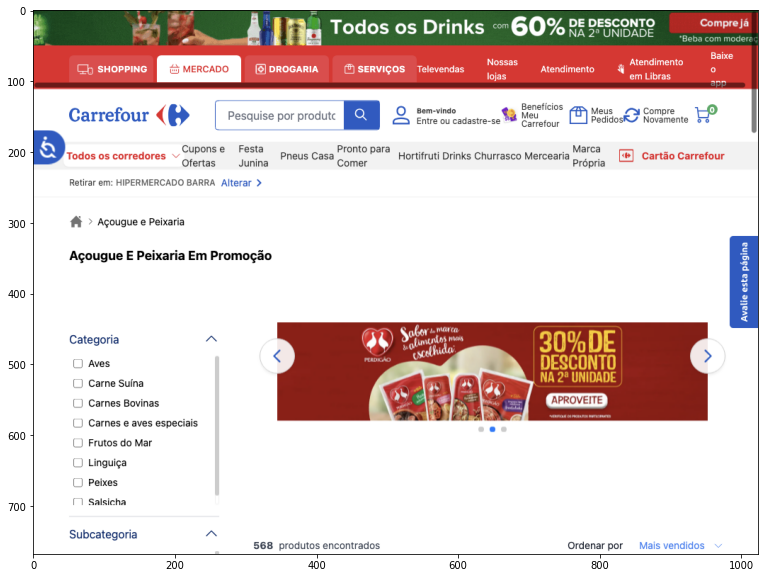

In [21]:
######## Visualizando Navegação Durante o processo de coleta ########
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

#figure = wd.find_elements(By.XPATH, '//div[@class="rev_wrap ui_columns is-multiline"]')[4].screenshot_as_png
figure = wd.find_elements(By.XPATH, '/html')[0].screenshot_as_png
im = Image.open(BytesIO(figure))
plt.figure(figsize=(15,10))
plt.imshow(im)
plt.show()

In [ ]:
# Fechando popup inicial
try:
    close_popup = wd.find_element(By.XPATH, '//button[@title="Fechar modal de regionalização"]') #href="/icons.svg#X" title="Fechar modal de regionalização"
    close_popup.click()
except:
    pass

In [9]:
# Selecionando Retirar na Loja
try:
    initial_popup = wd.find_element(By.XPATH, '//div[@aria-label="Retire na Loja"]') 
    initial_popup.click()
except:
    pass

In [10]:
# Selecionando a Cidade RIO DE JANEIRO - RJ
try:
    initial_popup = wd.find_element(By.XPATH, '//select[@id="selectCity"]') 
    initial_popup.click()
    initial_popup = Select(initial_popup)
    initial_popup.select_by_visible_text('RIO DE JANEIRO - RJ')
    initial_popup = wd.find_element(By.XPATH, '//article[@role="presentation"]')
    initial_popup.click()
except:
    pass

In [15]:
# Selecionando Bebidas do menu
wd.execute_script("window.scrollTo(0, 0)")
try:
    select_menu = wd.find_element(By.XPATH, '//*[@id="__next"]/nav/div/button') # XPATH 'Todos os corredores' direto da inspeção
    select_menu.click()
    select_menu = wd.find_element(By.XPATH, '//*[@id="__next"]/nav/div/div/div/aside/ul/li[4]/a')
    select_menu.click()
    select_menu = wd.find_element(By.XPATH, '//*[@id="__next"]/nav/div/button') # XPATH 'Todos os corredores' direto da inspeção
    select_menu.click()
except:
    pass

In [17]:
rename = {'0_x': 'descricao', '0_y': 'preco'}
df_market = pd.DataFrame(columns = ['descricao', 'preco', 'tipo', 'fornecedor'])

# Descendo a página para terminar de carregá-la
wd.execute_script("window.scrollTo(0, 500)")
time.sleep(4)
wd.execute_script("window.scrollTo(0, 2000)")
time.sleep(4)
wd.execute_script("window.scrollTo(0, 2500)")
time.sleep(4)

# Capturando a quantidade de páginas a se percorrer
page_list = wd.find_elements(By.XPATH, '//*[@id="__next"]/main/section[2]/div[2]/div[2]/div[5]/div[2]/div[1]/div/div')
page_list = [item.text for item in page_list]
current_page_index = int(page_list[1])
last_page_index = int(page_list[-2])

# Loop de captura de preços
while current_page_index <= 6: # last_page_index:       para percorrer todas as páginas basta descomentar "last_page_index:"
    
    # Descendo a página para terminar de carregá-la
    time.sleep(4)
    wd.execute_script("window.scrollTo(0, 500)")
    time.sleep(4)
    wd.execute_script("window.scrollTo(0, 2000)")
    time.sleep(4)
    wd.execute_script("window.scrollTo(0, 2500)")
    time.sleep(4)

    # Capturando descrições dos itens
    description = wd.find_elements(By.XPATH, '//a[@data-testid="product-link"]')
    description_list = [desc.text for desc in description]

    # Filtrando o preço desconto
    price_list = []
    for i in wd.find_elements(By.XPATH, '//span[@data-test-id="price"]'):
        if i.get_attribute('class') != 'md:text-sm text-xs line-through text-monet-300':
            price_list.append(i.text)

    description_df = pd.DataFrame(description_list)
    price_df = pd.DataFrame(price_list)

    df_temp = description_df.merge(price_df, right_index=True, left_index=True, how='outer')
    df_temp = df_temp[-(df_temp.isin(['']))].dropna().rename(columns=rename)
    df_temp['tipo'] = df_temp['descricao'].str.split(' ', expand=True)[0]
    df_temp.reset_index(inplace=True, drop=True)
    df_market = pd.concat([df_market, df_temp], ignore_index=True)

    for i in wd.find_elements(By.XPATH, '//*[@id="__next"]/main/section[2]/div[2]/div[2]/div[5]/div[2]/div[1]/div/div'):
        try:
            page = int(i.text)
            if page == current_page_index + 1:
                current_page_index += 1
                i.click()
                break
        except:
            pass


    print(f'Página {current_page_index}/{last_page_index}')


df_market['fornecedor'] = 'carrefour'

# eleminando duplicatas
df_market = df_market[-df_market['descricao'].duplicated()].reset_index(drop=True)

# formando coluna preço
#df_market['preco'] = df_market['preco'].str.replace(r'R\$', '', regex=True).str.strip().str.replace(',', '.')
#df_market['preco'] = df_market['preco'].astype('float64')

print('Terminou')

2
3
4
5
6
7
Terminou


In [19]:
df_market

,descricao,preco,tipo,fornecedor
0,Refresco Saborizado em Pó com Fruta Sabor Lara...,"R$ 1,19",Refresco,carrefour
1,Refresco Saborizado em Pó com Fruta Sabor Uva ...,"R$ 1,19",Refresco,carrefour
2,Refresco Saborizado em Pó com Fruta Sabor Mara...,"R$ 1,19",Refresco,carrefour
3,Refresco Saborizado em Pó com Fruta Sabor Limã...,"R$ 1,19",Refresco,carrefour
4,Refresco Saborizado em Pó com Fruta Sabor Lara...,"R$ 1,19",Refresco,carrefour
...,...,...,...,...
108,Coca-Cola Lata 350 ml,"R$ 3,69",Coca-Cola,carrefour
109,Refresco Saborizado em Pó com Fruta Sabor Goia...,"R$ 1,29",Refresco,carrefour
110,Cerveja Heineken Keg 5L,"R$ 123,59",Cerveja,carrefour
111,Néctar de Maracujá Del Valle 1 L,"R$ 7,79",Néctar,carrefour


In [20]:
# Selecionando Açougue e Peixaria do menu
wd.execute_script("window.scrollTo(0, 0)")
try:
    select_menu = wd.find_element(By.XPATH, '//*[@id="__next"]/nav/div/button') # XPATH 'Todos os corredores' direto da inspeção
    select_menu.click()
    select_menu = wd.find_element(By.XPATH, '//*[@id="__next"]/nav/div/div/div/aside/ul/li[6]/a')
    select_menu.click()
    select_menu = wd.find_element(By.XPATH, '//*[@id="__next"]/nav/div/button') # XPATH 'Todos os corredores' direto da inspeção
    select_menu.click()
except:
    pass

In [22]:
# Descendo a página para terminar de carregá-la
wd.execute_script("window.scrollTo(0, 500)")
time.sleep(4)
wd.execute_script("window.scrollTo(0, 1000)")
time.sleep(4)
wd.execute_script("window.scrollTo(0, 1500)")
time.sleep(4)

# Capturando a quantidade de páginas a se percorrer
page_list = wd.find_elements(By.XPATH, '//*[@id="__next"]/main/section[2]/div[2]/div[2]/div[5]/div[2]/div[1]/div/div')
page_list = [item.text for item in page_list]
current_page_index = int(page_list[1])
last_page_index = int(page_list[-2])

# Loop de captura de preços
while current_page_index <= 6: # last_page_index:       para percorrer todas as páginas basta descomentar "last_page_index:"
    
    # Descendo a página para terminar de carregá-la
    time.sleep(4)
    wd.execute_script("window.scrollTo(0, 500)")
    time.sleep(4)
    wd.execute_script("window.scrollTo(0, 1000)")
    time.sleep(4)
    wd.execute_script("window.scrollTo(0, 1500)")
    time.sleep(4)

    # Capturando descrições dos itens
    description = wd.find_elements(By.XPATH, '//a[@data-testid="product-link"]')
    description_list = [desc.text for desc in description]

    # Filtrando o preço desconto
    price_list = []
    for i in wd.find_elements(By.XPATH, '//span[@data-test-id="price"]'):
        if i.get_attribute('class') != 'md:text-sm text-xs line-through text-monet-300':
            price_list.append(i.text)

    description_df = pd.DataFrame(description_list)
    price_df = pd.DataFrame(price_list)

    df_temp = description_df.merge(price_df, right_index=True, left_index=True, how='outer')
    df_temp = df_temp[-(df_temp.isin(['']))].dropna().rename(columns=rename)
    df_temp['tipo'] = df_temp['descricao'].str.split(' ', expand=True)[0]
    df_temp.reset_index(inplace=True, drop=True)
    df_market = pd.concat([df_market, df_temp], ignore_index=True)

    for i in wd.find_elements(By.XPATH, '//*[@id="__next"]/main/section[2]/div[2]/div[2]/div[5]/div[2]/div[1]/div/div'):
        try:
            page = int(i.text)
            if page == current_page_index + 1:
                current_page_index += 1
                i.click()
                break
        except:
            pass


    print(f'Página {current_page_index}/{last_page_index}')


df_market['fornecedor'] = 'carrefour'

# eleminando duplicatas
df_market = df_market[-df_market['descricao'].duplicated()].reset_index(drop=True)

# formando coluna preço
#df_market['preco'] = df_market['preco'].str.replace(r'R\$', '', regex=True).str.strip().str.replace(',', '.')
#df_market['preco'] = df_market['preco'].astype('float64')

print('Terminou')

2
3
4
5
6
7
Terminou


In [ ]:
wd.quit()

## Salvando dados em database

agora os dados serão salvos em um servidor MySQL local para consultas posteriores

In [ ]:
# importando lib
import sqlalchemy

# configuração do databse MySQL
db_host = '192.168.0.119'
db_user = 'admin'
db_password = 'admin'
db_name = 'super_market'

# URL de conexão ao database
db_url = f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}'

# Criando engine
engine = sqlalchemy.create_engine(db_url)

In [ ]:
# Gravando dados na tabela produtos
df_market.to_sql('produtos', con=engine, index=False, if_exists='append')